# **CLARA: Enhancing Multimodal Sentiment Analysis via Efficient Vision-Language Fusion**

## ***HFM Dataset***
---

## 👥 Authors

**Phuong Lam** · lamphuong.ict89@gmail.com · Ho Chi Minh City University of Foreign Languages-Information Technology (HUFLIT), Vietnam

**Tuoi Thi Phan** · pttuoi@ntt.edu.vn · Nguyen Tat Thanh University, Vietnam

**Thien Khai Tran** ✉️ · thientk@huit.edu.vn · Ho Chi Minh City University of Industry and Trade (HUIT), Vietnam

---

## 📝 About

**CLARA** (Co-attention Learning for Robust multimodal sentiment Analysis) is a parameter-efficient framework for multimodal hate speech detection in memes, where hateful meaning emerges from image-text combinations.

**Key Highlights:**
- **87.99% F1-Macro** on HFM dataset (SOTA)
- **4.97% trainable parameters** (14,18M / 285,47M)
- 📄 Under review at *The Visual Computer* (Springer)
- GitHub: https://github.com/phuonglamgithub/CLARA
- DOI: https://doi.org/10.5281/zenodo.17862924

**Architecture:** CLIP (vision) + DeBERTa (text) + LoRA adapters + Bidirectional Co-Attention + Verification Module




## **(0) Installing Library**

In [1]:
import sys, importlib
def _pip_quiet(pkgs):
    import subprocess
    for p in pkgs:
        try:
            importlib.import_module(p.split("[")[0].split("==")[0])
        except Exception:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", p])

_pip_quiet([
    "transformers==4.42.4",
    "peft==0.11.1",
    "accelerate>=0.33.0",
    "kaleido",
    "plotly",
    "scikit-learn"
])


/usr/local/lib/python3.12/dist-packages/kaleido/_sync_server.py:11: UserWarning: 


This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.

  from .kaleido import Kaleido


## **(1) IMPORTS & CONFIG**

In [ ]:
print("="*76)
print("🚀 CLARA (vHFM) — HFM Multimodal Sentiment (image + text)")
print("="*76)

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    print("✅ Google Drive mounted")
except Exception:
    print("⚠️  Not in Colab environment")

import os, random, warnings, ast
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW

from transformers import (
    CLIPProcessor, CLIPVisionModel,
    DebertaV2Tokenizer, DebertaV2Model,
    get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, TaskType

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import plotly.graph_objects as go
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

CONFIG = {
    # Paths (HFM)
    "text_dir":   "/your/path/Dataset/HFM/text",
    "image_root": "/your/path/Dataset/HFM",

    # Models
    "vision_model_id": "openai/clip-vit-base-patch32",
    "text_model_id":   "microsoft/deberta-v3-base",

    # Fusion
    "hidden_dim": 512,
    "num_classes": 3,              # vẫn 3 chiều (Pos/Neu/Neg); report linh động theo lớp có thật
    "coattn_layers": 2,
    "coattn_heads": 8,
    "coattn_dropout": 0.1,

    # LoRA
    "enable_clip_lora": True,
    "lora_clip": { "r": 32, "alpha": 64,  "dropout": 0.05 },
    "lora_deb":  { "r": 64, "alpha": 128, "dropout": 0.10 },

    # Train
    "batch_size": 128,      # nếu OOM thì giảm 32/24/16
    "learning_rate": 1e-4,
    "weight_decay": 0.01,
    "max_epochs": 50,
    "early_stopping_patience": 10,
    "warmup_ratio": 0.1,

    # Data / System
    "max_length_percentile": 98,
    "max_length_sample_size": 1000,
    "amp_prefer_bf16": True,
    "grad_checkpointing": False,   # 🔧 tắt checkpointing để tránh lỗi backward twice
    "num_workers": 8,
    "pin_memory": True,

    # CLARA losses
    "use_contrastive": True,
    "contrastive_weight": 0.05,

    "seed": 42,
}

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CONFIG["seed"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device: {device}")
if torch.cuda.is_available():
    print("   GPU:", torch.cuda.get_device_name(0))
    print("   CUDA:", torch.version.cuda)

use_bf16 = bool(CONFIG["amp_prefer_bf16"] and torch.cuda.is_available() and torch.cuda.is_bf16_supported())
amp_dtype = torch.bfloat16 if use_bf16 else torch.float16
print(f"AMP dtype prefer: {'bf16' if use_bf16 else 'fp16'}")

🚀 CLARA (vHFM) — HFM Multimodal Sentiment (image + text)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted
✅ Device: cuda
   GPU: NVIDIA L4
   CUDA: 12.6
AMP dtype prefer: bf16


## **(2) DATA LOADING — HFM**

In [ ]:
@dataclass
class HFMSample:
    image_path: str
    text: str
    label: int       # 0=Pos,1=Neu,2=Neg
    split: str       # 'train' | 'val' | 'test'
    image_id: str

class HFMLoader:
    """ 
    HFM loader: 
    text_dir/ train.txt, val.txt (or valid.txt), test.txt 
    per line: ['image_id', 'tweet text', label] 
    photo: HFM/{train,val,test}/image/{image_id}.jpg|... 
    """
    def __init__(self, text_dir: str, image_root: str):
        self.text_dir = Path(text_dir)
        self.image_root = Path(image_root)
        self.samples: List[HFMSample] = []
        self.id2name = {0: "positive", 1: "neutral", 2: "negative"}
        self.name2id = {v: k for k, v in self.id2name.items()}
        self.label_ids_present: List[int] = []

    def _find_image(self, image_id: str, split: str):
        exts = [".jpg",".JPG",".jpeg",".JPEG",".png",".PNG",".bmp"]
        split_dirs = [self.image_root / split / "image"]
        if split == "val":
            split_dirs.append(self.image_root / "valid" / "image")
        split_dirs.append(self.image_root / "image")

        for d in split_dirs:
            if not d.exists():
                continue
            for e in exts:
                p = d / f"{image_id}{e}"
                if p.exists():
                    return str(p)
        return None

    def _load_split(self, fname: str, split: str):
        path = self.text_dir / fname
        if not path.exists():
            return []

        print(f"📄 Loading {fname} for split={split} ...", end=" ")
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            lines = f.readlines()

        split_samples: List[HFMSample] = []
        skip_parse = 0; skip_label = 0; skip_img = 0

        for ln, line in enumerate(lines, 1):
            line = line.strip()
            if not line:
                continue
            try:
                rec = ast.literal_eval(line)
            except Exception:
                skip_parse += 1
                continue
            if not isinstance(rec, (list, tuple)) or len(rec) < 3:
                skip_parse += 1
                continue

            image_id = str(rec[0]).strip()
            text = str(rec[1]).strip()
            raw_label = rec[2]

            try:
                if isinstance(raw_label, str):
                    raw_label = raw_label.strip().lower()
                    if raw_label in ["0","1","2"]:
                        lab_id = int(raw_label)
                    elif raw_label in ["positive","pos","+"]:
                        lab_id = 0
                    elif raw_label in ["neutral","neu","neut"]:
                        lab_id = 1
                    elif raw_label in ["negative","neg","-"]:
                        lab_id = 2
                    else:
                        skip_label += 1
                        continue
                else:
                    lab_id = int(raw_label)
            except Exception:
                skip_label += 1
                continue

            if lab_id not in [0,1,2]:
                skip_label += 1
                continue

            img_path = self._find_image(image_id, split)
            if img_path is None:
                skip_img += 1
                continue

            split_samples.append(HFMSample(
                image_path=img_path,
                text=text,
                label=lab_id,
                split=split,
                image_id=image_id
            ))

        cnt = Counter(s.label for s in split_samples)
        parts = []
        if cnt.get(0,0) > 0: parts.append(f"Pos={cnt.get(0,0)}")
        if cnt.get(1,0) > 0: parts.append(f"Neu={cnt.get(1,0)}")
        if cnt.get(2,0) > 0: parts.append(f"Neg={cnt.get(2,0)}")
        print(f"✓ {len(split_samples)} samples | " + ", ".join(parts) +
              (f"  (skip parse={skip_parse}, label={skip_label}, img={skip_img})" if (skip_parse+skip_label+skip_img)>0 else ""))

        return split_samples

    def load(self):
        self.samples.clear()
        print("\n📂 Loading HFM dataset ...")

        split_map = [
            ("train.txt","train"),
            ("val.txt","val"),
            ("valid.txt","val"),
            ("test.txt","test"),
        ]
        loaded_splits = set()
        for fname, split in split_map:
            if split in loaded_splits:
                continue
            path = self.text_dir / fname
            if not path.exists():
                continue
            sps = self._load_split(fname, split)
            self.samples.extend(sps)
            loaded_splits.add(split)

        if not self.samples:
            raise RuntimeError("❌ Không load được sample nào. Kiểm tra đường dẫn HFM/text và format dòng.")

        all_cnt = Counter(s.label for s in self.samples)
        ids_present = sorted(all_cnt.keys())
        self.label_ids_present = ids_present

        msg_parts = []
        if all_cnt.get(0,0)>0: msg_parts.append(f"Pos={all_cnt.get(0,0)}")
        if all_cnt.get(1,0)>0: msg_parts.append(f"Neu={all_cnt.get(1,0)}")
        if all_cnt.get(2,0)>0: msg_parts.append(f"Neg={all_cnt.get(2,0)}")
        print(f"\n✅ Total={len(self.samples)} | " + ", ".join(msg_parts))

        return self.samples

    def get_split(self, split: str) -> List[HFMSample]:
        return [s for s in self.samples if s.split == split]

loader = HFMLoader(CONFIG["text_dir"], CONFIG["image_root"])
all_samples = loader.load()
train_samples = loader.get_split("train")
val_samples   = loader.get_split("val")
test_samples  = loader.get_split("test")

print("\n📦 Split sizes:")
print(f"   Train = {len(train_samples)}")
print(f"   Val   = {len(val_samples)}")
print(f"   Test  = {len(test_samples)}")


📂 Loading HFM dataset ...
📄 Loading train.txt for split=train ... ✓ 19816 samples | Pos=11174, Neu=8642  (skip parse=0, label=0, img=9224)
📄 Loading val.txt for split=val ... ✓ 2410 samples | Pos=1410, Neu=1000
📄 Loading test.txt for split=test ... ✓ 2409 samples | Pos=1404, Neu=1005

✅ Total=24635 | Pos=13988, Neu=10647

📦 Split sizes:
   Train = 19816
   Val   = 2410
   Test  = 2409


## **(3) EDA**


📄 10 sample TEXT (train):
[01] id=822950451779948544 | label=positive | this is texas y 'all . an anti-trump march this evening in austin on the ann richards bridge . come together ? hell , we 're just getting started
[02] id=933506146786316288 | label=neutral  | welcome to the twitter page of videaprojaekt . here you can buy lootboxes ( for 10 € each ) with tweets on random topics . if you earn <num> legendary tweets , you can unlock dark saber ! preorder <nu…
[03] id=822588104745816066 | label=positive | best # cowboys player of 2016 round of 32 retweet for zack martin like for jj wilcox # cowboysnation
[04] id=699891661862739968 | label=neutral  | roses ordered for 13th in time for valentines turned up 16th , dead . awesome service from <user>
[05] id=822229287994527744 | label=positive | imagine how beautiful jess is gonna look on her actual wedding day omg
[06] id=823314381052215297 | label=positive | when ur mad as hell , but words aren 't enough
[07] id=711357935591366657 | lab

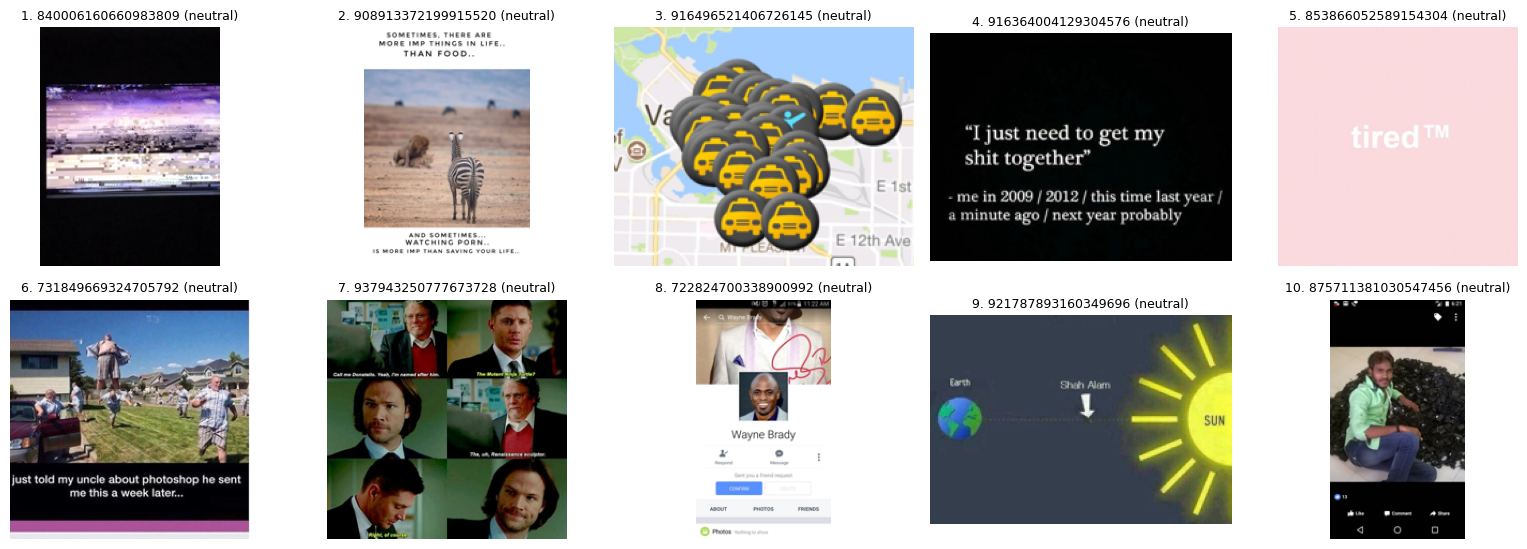


📊 Distribution by split:



📊 Total samples per class:


In [ ]:
def show_sample_texts(samples: List[HFMSample], k=10, max_chars=200):
    print(f"\n📄 {min(k, len(samples))} sample TEXT (train):")
    for i, s in enumerate(random.sample(samples, min(k, len(samples)))):
        txt = s.text.replace("\n"," ").strip()
        if len(txt) > max_chars:
            txt = txt[:max_chars] + "…"
        lab_name = loader.id2name.get(s.label, str(s.label))
        print(f"[{i+1:02d}] id={s.image_id} | label={lab_name:<8} | {txt}")

def show_sample_images(samples: List[HFMSample], k=10, ncols=5, thumb=(224,224)):
    k = min(k, len(samples))
    if k == 0:
        print("⚠️ No sample images are available.")
        return
    nrows = (k + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.8*nrows))
    if nrows == 1:
        axes = [axes]
    axes = [ax for row in axes for ax in (row if isinstance(row, (list,tuple,np.ndarray)) else [row])]

    for i in range(k):
        s = samples[i]
        ax = axes[i]
        try:
            img = Image.open(s.image_path).convert("RGB")
            img.thumbnail(thumb)
        except Exception:
            img = Image.new("RGB", thumb, (220,220,220))
        lab_name = loader.id2name.get(s.label, str(s.label))
        ax.imshow(img)
        ax.set_title(f"{i+1}. {s.image_id} ({lab_name})", fontsize=9)
        ax.axis("off")
    for j in range(k, nrows*ncols):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()

show_sample_texts(train_samples, k=10)
show_sample_images(train_samples, k=10, ncols=5)

def plot_split_distribution(train, val, test):
    all_s = list(train) + list(val) + list(test)
    if not all_s:
        print("⚠️ No data available to plot the distribution.")
        return
    label_ids = sorted(set(s.label for s in all_s))
    data = []
    for split_name, S in [("Train", train), ("Val", val), ("Test", test)]:
        for lab in label_ids:
            data.append({
                "Split": split_name,
                "ClassId": lab,
                "Class": loader.id2name[lab].capitalize(),
                "Count": sum(1 for s in S if s.label == lab)
            })
    df = pd.DataFrame(data)

    fig = go.Figure()
    for split_name in ["Train","Val","Test"]:
        d = df[df["Split"] == split_name]
        fig.add_trace(go.Bar(
            name=split_name,
            x=d["Class"],
            y=d["Count"],
            text=d["Count"],
            textposition="auto"
        ))
    fig.update_layout(
        title="HFM — Dataset Distribution by Split & Class",
        barmode="group",
        template="plotly_white",
        xaxis_title="Class",
        yaxis_title="Number of samples",
        height=420
    )
    fig.show()

def plot_class_sizes(train, val, test):
    all_s = list(train) + list(val) + list(test)
    if not all_s:
        return
    label_ids = sorted(set(s.label for s in all_s))
    rows = []
    for lab in label_ids:
        rows.append({
            "ClassId": lab,
            "Class": loader.id2name[lab].capitalize(),
            "Total": sum(1 for s in all_s if s.label == lab)
        })
    df = pd.DataFrame(rows)
    fig = go.Figure(go.Bar(
        x=df["Class"],
        y=df["Total"],
        text=df["Total"],
        textposition="auto"
    ))
    fig.update_layout(
        title="HFM — Total Samples per Class",
        template="plotly_white",
        xaxis_title="Class",
        yaxis_title="Total samples",
        height=380
    )
    fig.show()

print("\n📊 Distribution by split:")
plot_split_distribution(train_samples, val_samples, test_samples)
print("\n📊 Total samples per class:")
plot_class_sizes(train_samples, val_samples, test_samples)

## **(4) PROCESSORS + DATASET**

In [5]:
print("\n Loading processors (CLIP & DeBERTa)...")
clip_processor = CLIPProcessor.from_pretrained(CONFIG["vision_model_id"])
deb_tokenizer  = DebertaV2Tokenizer.from_pretrained(CONFIG["text_model_id"])
print("✅ Processors ready")

print("\n Estimating MAX_LENGTH from HFM texts...")
chk = random.sample(all_samples, min(CONFIG["max_length_sample_size"], len(all_samples)))
lens = [len(s.text.split()) for s in chk]
p = CONFIG["max_length_percentile"]
max_len = int(np.percentile(lens, p)) if lens else 128
MAX_LENGTH = max(64, max_len)
print(f"   P{p} = {max_len} → MAX_LENGTH = {MAX_LENGTH}")

class HFMDataset(Dataset):
    def __init__(self, samples: List[HFMSample], clip_processor, tokenizer, max_length: int):
        self.samples = samples
        self.cp = clip_processor
        self.tk = tokenizer
        self.max_len = max_length

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        try:
            img = Image.open(s.image_path).convert("RGB")
        except Exception:
            img = Image.new("RGB", (224,224), (0,0,0))
        ie = self.cp(images=img, return_tensors="pt")
        te = self.tk(
            s.text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "pixel_values":  ie["pixel_values"].squeeze(0),
            "input_ids":     te["input_ids"].squeeze(0),
            "attention_mask":te["attention_mask"].squeeze(0),
            "labels": torch.tensor(s.label, dtype=torch.long)
        }

use_cuda = torch.cuda.is_available()
pin_mem = bool(CONFIG["pin_memory"] and use_cuda)

cnt = Counter(s.label for s in train_samples)

# Weighted sampler
arr = np.array([cnt.get(0,1), cnt.get(1,1), cnt.get(2,1)], dtype=np.float32)
arr = np.clip(arr, 1.0, None)
inv = (arr.sum() / arr)
weights_per_sample = [inv[s.label] for s in train_samples]
train_sampler = WeightedRandomSampler(weights_per_sample, num_samples=len(weights_per_sample), replacement=True)

train_ds = HFMDataset(train_samples, clip_processor, deb_tokenizer, MAX_LENGTH)
val_ds   = HFMDataset(val_samples,   clip_processor, deb_tokenizer, MAX_LENGTH)
test_ds  = HFMDataset(test_samples,  clip_processor, deb_tokenizer, MAX_LENGTH)

train_loader = DataLoader(
    train_ds,
    batch_size=CONFIG["batch_size"],
    sampler=train_sampler,
    num_workers=CONFIG["num_workers"],
    pin_memory=pin_mem,
    persistent_workers=False,
    prefetch_factor=2
)
val_loader = DataLoader(
    val_ds,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=pin_mem,
    persistent_workers=False,
    prefetch_factor=2
)
test_loader = DataLoader(
    test_ds,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=pin_mem,
    persistent_workers=False,
    prefetch_factor=2
)

print(f"✅ DataLoaders ready → batch={CONFIG['batch_size']} | steps/train={len(train_loader)}")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



 Loading processors (CLIP & DeBERTa)...
✅ Processors ready

 Estimating MAX_LENGTH from HFM texts...
   P98 = 33 → MAX_LENGTH = 64
✅ DataLoaders ready → batch=128 | steps/train=155


## **(5) MODEL CLARA & ADAPTER**

In [6]:
class CoAttentionBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim*4), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim*4, hidden_dim), nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(hidden_dim)

    def forward(self, q, kv):
        x,_ = self.attn(q, kv, kv)
        x = self.norm1(q + x)
        y = self.ffn(x)
        y = self.norm2(x + y)
        return y

class CoAttentionStack(nn.Module):
    def __init__(self, vision_dim, text_dim, hidden_dim, layers=2, heads=8, dropout=0.1):
        super().__init__()
        self.v_proj = nn.Linear(vision_dim, hidden_dim)
        self.t_proj = nn.Linear(text_dim, hidden_dim)
        self.blocks = nn.ModuleList([CoAttentionBlock(hidden_dim, heads, dropout) for _ in range(layers)])

    def forward(self, v_feat, t_feat):
        v = self.v_proj(v_feat).unsqueeze(1)
        t = self.t_proj(t_feat).unsqueeze(1)
        x = t; kv = v
        for blk in self.blocks:
            x = blk(x, kv)
        return x.squeeze(1)

class PredictionModule(nn.Module):
    def __init__(self, hidden_dim, num_classes, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, h):
        logits = self.net(h)
        probs = F.softmax(logits, dim=-1)
        return logits, probs

class VerificationModule(nn.Module):
    def __init__(self, hidden_dim, num_classes, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, h):
        logits = self.net(h)
        probs = F.softmax(logits, dim=-1)
        return logits, probs

class UncertaintyEstimator(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim//2, 1),
            nn.Sigmoid()
        )
    def forward(self, h):
        return self.net(h)

class FeedbackModule(nn.Module):
    def __init__(self, hidden_dim, num_classes, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim + num_classes, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )
    def forward(self, h, v_signal):
        return self.net(torch.cat([h, v_signal], dim=-1))

def _collect_linear_leaf_names(model: nn.Module):
    names=set()
    for n,m in model.named_modules():
        if isinstance(m, nn.Linear):
            names.add(n.split(".")[-1].lower())
    return names

def find_targets_for_clip(model: nn.Module):
    names = _collect_linear_leaf_names(model)
    pref  = {"q_proj","k_proj","v_proj","out_proj"}
    cand  = [n for n in names if n in pref]
    if cand: return cand
    if "proj" in names: return ["proj"]
    return ["q_proj","k_proj","v_proj","out_proj"]

def find_targets_for_deberta(model: nn.Module):
    names = _collect_linear_leaf_names(model)
    pref  = {"query_proj","key_proj","value_proj","o_proj"}
    cand  = [n for n in names if n in pref]
    if cand: return cand
    pref2 = {"q_proj","k_proj","v_proj","out_proj"}
    cand  = [n for n in names if n in pref2]
    if cand: return cand
    return ["dense"]

class _VisionAdapter(nn.Module):
    def __init__(self, model_like: nn.Module):
        super().__init__()
        backbone = model_like
        for _ in range(5):
            if hasattr(backbone, "get_base_model"):
                try:
                    backbone = backbone.get_base_model(); continue
                except Exception:
                    pass
            if hasattr(backbone, "vision_model") and isinstance(backbone.vision_model, nn.Module):
                backbone = backbone.vision_model; continue
            if hasattr(backbone, "base_model") and isinstance(backbone.base_model, nn.Module):
                backbone = backbone.base_model; continue
            if hasattr(backbone, "model") and isinstance(backbone.model, nn.Module):
                backbone = backbone.model; continue
            if hasattr(backbone, "module") and isinstance(backbone.module, nn.Module):
                backbone = backbone.module; continue
            break
        self.backbone = backbone

    def forward(self, pixel_values, *args, **kwargs):
        return self.backbone(pixel_values=pixel_values)

class CLARAModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        H = cfg["hidden_dim"]; heads = cfg["coattn_heads"]; layers = cfg["coattn_layers"]
        num_classes = cfg["num_classes"]

        print("\n🔧 Initializing CLARA Model for HFM …")
        _clip_raw = CLIPVisionModel.from_pretrained(cfg["vision_model_id"])
        _deb_raw  = DebertaV2Model.from_pretrained(cfg["text_model_id"])

        # grad_checkpointing = False trong CONFIG nên đoạn dưới không chạy
        if cfg["grad_checkpointing"]:
            vm = getattr(_clip_raw, "vision_model", None)
            if vm is not None and hasattr(vm, "gradient_checkpointing_enable"):
                vm.gradient_checkpointing_enable()
            if hasattr(_deb_raw, "gradient_checkpointing_enable"):
                _deb_raw.gradient_checkpointing_enable()

        if cfg["enable_clip_lora"]:
            clip_targets = find_targets_for_clip(_clip_raw)
            lcfg = LoraConfig(
                r=cfg["lora_clip"]["r"],
                lora_alpha=cfg["lora_clip"]["alpha"],
                lora_dropout=cfg["lora_clip"]["dropout"],
                bias="none",
                target_modules=clip_targets,
                task_type=TaskType.FEATURE_EXTRACTION
            )
            clip_lora = get_peft_model(_clip_raw, lcfg)
            self.vision = _VisionAdapter(clip_lora)
            print(f"   ✓ LoRA(CLIP) targets={clip_targets}")
        else:
            for p in _clip_raw.parameters():
                p.requires_grad = False
            _clip_raw.eval()
            self.vision = _VisionAdapter(_clip_raw)
            print("   ✓ CLIP frozen (no LoRA)")

        deb_targets = find_targets_for_deberta(_deb_raw)
        lcfg_deb = LoraConfig(
            r=cfg["lora_deb"]["r"],
            lora_alpha=cfg["lora_deb"]["alpha"],
            lora_dropout=cfg["lora_deb"]["dropout"],
            bias="none",
            target_modules=deb_targets,
            task_type=TaskType.FEATURE_EXTRACTION
        )
        self.text = get_peft_model(_deb_raw, lcfg_deb)
        print(f"   ✓ LoRA(DeBERTa) targets={deb_targets}")

        v_dim = 768
        t_dim = self.text.config.hidden_size
        self.fusion = CoAttentionStack(
            vision_dim=v_dim,
            text_dim=t_dim,
            hidden_dim=H,
            layers=layers,
            heads=heads,
            dropout=cfg["coattn_dropout"]
        )
        self.pred = PredictionModule(H, num_classes)
        self.veri = VerificationModule(H, num_classes)
        self.unc  = UncertaintyEstimator(H)
        self.feed = FeedbackModule(H, num_classes)
        self.hidden_dim = H
        print("✅ Model initialized")

    def forward(self, pixel_values, input_ids, attention_mask):
        v_out = self.vision(pixel_values)
        v_feat = v_out.last_hidden_state.mean(dim=1)

        t_out = self.text(input_ids=input_ids, attention_mask=attention_mask)
        t_seq = t_out.last_hidden_state
        mask = attention_mask.unsqueeze(-1).float()
        t_feat = (t_seq * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)

        fused = self.fusion(v_feat, t_feat)

        lg_p, pr_p = self.pred(fused)
        lg_v, pr_v = self.veri(fused)
        u = self.unc(fused)

        sig = pr_v - pr_p
        ref = self.feed(fused, sig)
        lg2, pr2 = self.pred(ref)

        return {
            "logits": lg2,
            "probs": pr2,
            "pred_logits": lg_p,
            "verify_logits": lg_v,
            "uncertainty": u
        }

    def print_stats(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"\n📊 Params: total={total:,} | trainable={trainable:,} ({trainable/max(total,1)*100:.2f}%)")

model = CLARAModel(CONFIG).to(device)
model.print_stats()




🔧 Initializing CLARA Model for HFM …
   ✓ LoRA(CLIP) targets=['k_proj', 'v_proj', 'q_proj', 'out_proj']
   ✓ LoRA(DeBERTa) targets=['query_proj', 'key_proj', 'value_proj']
✅ Model initialized

📊 Params: total=285,467,911 | trainable=14,180,359 (4.97%)


## **(6) EARLY STOPPING**

In [7]:
class EarlyStopping:
    """
    Simple early stopping on a validation metric (here: Macro-F1).
    If you already have an EarlyStopping in your file, you can remove this one.
    """
    def __init__(self, patience=10, mode="max", min_delta=0.0):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.best = None
        self.num_bad_epochs = 0
        self.should_stop = False

    def __call__(self, current, epoch):
        if self.best is None:
            self.best = current
            self.num_bad_epochs = 0
            return False

        if self.mode == "max":
            improvement = current - self.best
        else:
            improvement = self.best - current

        if improvement > self.min_delta:
            self.best = current
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            self.should_stop = True

        return self.should_stop


## **(7) TRAINER**

In [14]:
# Trainer
class Trainer:
    def __init__(self, model, train_loader, val_loader, cfg, device,
                 cls_weights=None, use_bf16=False, amp_dtype=torch.bfloat16):
        """
        Args:
            model        : CLARA model for HFM.
            train_loader : DataLoader for training set.
            val_loader   : DataLoader for validation set.
            cfg          : dict of config (learning_rate, weight_decay, max_epochs,
                           warmup_ratio, early_stopping_patience, contrastive_weight,
                           use_contrastive, ...).
            device       : torch.device.
            cls_weights  : tensor of class weights (for CrossEntropyLoss) or None.
            use_bf16     : whether to use bf16 mixed precision on GPU.
            amp_dtype    : dtype for autocast (torch.bfloat16 or torch.float16).
        """
        self.model = model
        self.tl = train_loader
        self.vl = val_loader
        self.cfg = cfg
        self.device = device

        # Optimizer & scheduler
        self.opt = AdamW(
            model.parameters(),
            lr=cfg["learning_rate"],
            weight_decay=cfg["weight_decay"]
        )
        total_steps = len(train_loader) * cfg["max_epochs"]
        self.sche = get_linear_schedule_with_warmup(
            self.opt,
            int(cfg["warmup_ratio"] * total_steps),
            total_steps
        )

        # Loss, early stopping, AMP
        if cls_weights is not None:
            cls_weights = cls_weights.to(device)
        self.ce = nn.CrossEntropyLoss(weight=cls_weights, label_smoothing=0.05)

        self.early = EarlyStopping(
            patience=cfg.get("early_stopping_patience", 10),
            mode="max"
        )

        self.use_bf16 = use_bf16
        self.amp_dtype = amp_dtype

        self.scaler = torch.cuda.amp.GradScaler(
            enabled=(not self.use_bf16 and torch.cuda.is_available())
        )

        # Best metric (Macro-F1 is the main metric)
        self.best_f1 = 0.0
        self.best_state = None

        # History for future analysis (no plotting here)
        self.history = {
            "epoch": [],
            "train_loss": [],
            "val_acc": [],
            "val_f1": [],              # Macro F1
            "lr": [],
            "best_val_f1_so_far": [],
        }

        print(
            f"AMP dtype: {'bf16' if self.use_bf16 else 'fp16'} "
            f"(GradScaler enabled={self.scaler.is_enabled()})"
        )

    # Optional contrastive loss
    def _contrastive(self, p_logits, v_logits):
        """Optional contrastive regularization between two logit heads."""
        if not self.cfg.get("use_contrastive", False):
            return torch.tensor(0.0, device=self.device)

        # Symmetric KL-divergence
        p_log = F.log_softmax(p_logits, dim=-1)
        v_prob = F.softmax(v_logits, dim=-1)
        kl1 = F.kl_div(p_log, v_prob, reduction="batchmean")

        v_log = F.log_softmax(v_logits, dim=-1)
        p_prob = F.softmax(p_logits, dim=-1)
        kl2 = F.kl_div(v_log, p_prob, reduction="batchmean")

        return 0.5 * (kl1 + kl2)

    # One training epoch
    def train_epoch(self, epoch_idx: int):
        self.model.train()
        total_loss = 0.0

        for batch in tqdm(
            self.tl,
            desc=f"Training (epoch {epoch_idx + 1})",
            leave=True,
            dynamic_ncols=True
        ):
            pixel_values = batch["pixel_values"].to(self.device, non_blocking=True)
            input_ids    = batch["input_ids"].to(self.device, non_blocking=True)
            attention    = batch["attention_mask"].to(self.device, non_blocking=True)
            labels       = batch["labels"].to(self.device, non_blocking=True)

            self.opt.zero_grad(set_to_none=True)

            if torch.cuda.is_available():
                ctx = torch.cuda.amp.autocast(dtype=self.amp_dtype)
            else:
                ctx = torch.autocast("cpu", dtype=torch.bfloat16, enabled=False)

            with ctx:
                out = self.model(
                    pixel_values,
                    input_ids=input_ids,
                    attention_mask=attention
                )

                # Expected heads in `out`:
                #   out["logits"]        : main classification head
                #   out["verify_logits"] : verification / uncertainty head
                #   out["pred_logits"]   : auxiliary head for contrastive loss
                loss_main = self.ce(out["logits"], labels)
                loss_ver  = self.ce(out["verify_logits"], labels)

                # Logits consistency (main vs verify head)
                loss_con = F.kl_div(
                    F.log_softmax(out["logits"], dim=-1),
                    F.softmax(out["verify_logits"], dim=-1),
                    reduction="batchmean"
                )

                # Optional contrastive term
                loss_ctr = self._contrastive(
                    out["pred_logits"],
                    out["verify_logits"]
                )

                loss = (
                    loss_main
                    + 0.35 * loss_ver
                    + 0.25 * loss_con
                    + self.cfg.get("contrastive_weight", 0.0) * loss_ctr
                )

            # Backward + step (AMP support)
            if self.scaler.is_enabled():
                self.scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.scaler.step(self.opt)
                self.scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.opt.step()

            self.sche.step()
            total_loss += loss.item()

            del loss, loss_main, loss_ver, loss_con, loss_ctr, out
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        avg_loss = total_loss / max(len(self.tl), 1)
        return avg_loss

    # Validation
    @torch.no_grad()
    def validate(self):
        self.model.eval()
        preds = []
        trues = []

        for batch in tqdm(self.vl, desc="Validation", leave=False):
            pixel_values = batch["pixel_values"].to(self.device, non_blocking=True)
            input_ids    = batch["input_ids"].to(self.device, non_blocking=True)
            attention    = batch["attention_mask"].to(self.device, non_blocking=True)
            labels       = batch["labels"].to(self.device, non_blocking=True)

            out = self.model(
                pixel_values,
                input_ids=input_ids,
                attention_mask=attention
            )
            logits = out["logits"]

            preds.extend(logits.argmax(dim=-1).cpu().numpy())
            trues.extend(labels.cpu().numpy())

        preds = np.array(preds)
        trues = np.array(trues)

        acc  = accuracy_score(trues, preds)
        f1_m = f1_score(trues, preds, average="macro")   # Macro-F1
        return acc, f1_m

    # Update history
    def _update_history(self, epoch, train_loss, val_acc, val_f1, best_f1_so_far):
        """Store training/validation stats for each epoch."""
        current_lr = self.opt.param_groups[0]["lr"]

        self.history["epoch"].append(epoch)
        self.history["train_loss"].append(train_loss)
        self.history["val_acc"].append(val_acc)
        self.history["val_f1"].append(val_f1)
        self.history["lr"].append(current_lr)
        self.history["best_val_f1_so_far"].append(best_f1_so_far)

    # Main training loop
    def train(self):
        print("\n" + "=" * 70)
        print("TRAINING STARTED (HFM / CLARA)")
        print("=" * 70)

        for epoch in range(self.cfg["max_epochs"]):
            train_loss = self.train_epoch(epoch)
            val_acc, val_f1 = self.validate()

            # Check if we have a new best Macro-F1
            is_new_best = val_f1 > self.best_f1
            if is_new_best:
                self.best_f1 = val_f1

            # Update history (with the updated best_f1)
            self._update_history(
                epoch=epoch + 1,
                train_loss=train_loss,
                val_acc=val_acc,
                val_f1=val_f1,
                best_f1_so_far=self.best_f1,
            )

            print(
                f"Epoch {epoch + 1:02d}/{self.cfg['max_epochs']} | "
                f"Train Loss={train_loss:.4f} | "
                f"Val Acc={val_acc:.4f} | "
                f"Val F1-M={val_f1:.4f} | "
                f"Best F1-M={self.best_f1:.4f}"
            )

            # Save best model checkpoint to clara_hfm.pt
            if is_new_best:
                self.best_state = {
                    k: v.detach().cpu().clone()
                    for k, v in self.model.state_dict().items()
                }
                torch.save(
                    {
                        "model_state": self.best_state,
                        "cfg": self.cfg,
                        "epoch": epoch + 1,
                        "best_val_f1": self.best_f1,
                        "history": self.history,
                    },
                    "clara_hfm.pt"
                )
                print(" New best F1-Macro! Saved to 'clara_hfm.pt'.")

            # Early stopping based on Macro-F1
            if self.early(val_f1, epoch):
                print("⏹ Early stopping triggered.")
                break

        # Load best state into the model (for later evaluation)
        if self.best_state is not None:
            self.model.load_state_dict(self.best_state)

        print(f"\n✅ Training finished! Best Val Macro-F1: {self.best_f1:.4f}")
        return self.best_f1

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    cfg=CONFIG,
    device=device,
    use_bf16=True,               # hoặc False
    amp_dtype=torch.bfloat16     # hoặc torch.float16
)

best_val_f1 = trainer.train()
history = trainer.history
print("Best Val Macro-F1:", best_val_f1)




AMP dtype: bf16 (GradScaler enabled=False)

TRAINING STARTED (HFM / CLARA)


Training (epoch 1): 100%|██████████| 155/155 [17:23<00:00,  6.73s/it]


Epoch 01/50 | Train Loss=1.0042 | Val Acc=0.7734 | Val F1-M=0.7702 | Best F1-M=0.7702
 New best F1-Macro! Saved to 'clara_hfm.pt'.


Training (epoch 2): 100%|██████████| 155/155 [07:18<00:00,  2.83s/it]


Epoch 02/50 | Train Loss=0.6424 | Val Acc=0.8490 | Val F1-M=0.8459 | Best F1-M=0.8459
 New best F1-Macro! Saved to 'clara_hfm.pt'.


Training (epoch 3): 100%|██████████| 155/155 [03:38<00:00,  1.41s/it]


Epoch 03/50 | Train Loss=0.5219 | Val Acc=0.8714 | Val F1-M=0.8675 | Best F1-M=0.8675
 New best F1-Macro! Saved to 'clara_hfm.pt'.


Training (epoch 4): 100%|██████████| 155/155 [02:13<00:00,  1.16it/s]


Epoch 04/50 | Train Loss=0.4485 | Val Acc=0.8680 | Val F1-M=0.8647 | Best F1-M=0.8675


Training (epoch 5): 100%|██████████| 155/155 [02:07<00:00,  1.21it/s]


Epoch 05/50 | Train Loss=0.3840 | Val Acc=0.8693 | Val F1-M=0.8671 | Best F1-M=0.8675


Training (epoch 6): 100%|██████████| 155/155 [01:59<00:00,  1.30it/s]


Epoch 06/50 | Train Loss=0.3325 | Val Acc=0.8614 | Val F1-M=0.8589 | Best F1-M=0.8675


Training (epoch 7): 100%|██████████| 155/155 [01:59<00:00,  1.30it/s]


Epoch 07/50 | Train Loss=0.3001 | Val Acc=0.8689 | Val F1-M=0.8672 | Best F1-M=0.8675


Training (epoch 8): 100%|██████████| 155/155 [01:58<00:00,  1.31it/s]


Epoch 08/50 | Train Loss=0.2866 | Val Acc=0.8635 | Val F1-M=0.8617 | Best F1-M=0.8675


Training (epoch 9): 100%|██████████| 155/155 [01:58<00:00,  1.31it/s]


Epoch 09/50 | Train Loss=0.2711 | Val Acc=0.8664 | Val F1-M=0.8643 | Best F1-M=0.8675


Training (epoch 10): 100%|██████████| 155/155 [01:58<00:00,  1.30it/s]


Epoch 10/50 | Train Loss=0.2615 | Val Acc=0.8593 | Val F1-M=0.8582 | Best F1-M=0.8675


Training (epoch 11): 100%|██████████| 155/155 [01:59<00:00,  1.30it/s]


Epoch 11/50 | Train Loss=0.2597 | Val Acc=0.8801 | Val F1-M=0.8772 | Best F1-M=0.8772
 New best F1-Macro! Saved to 'clara_hfm.pt'.


Training (epoch 12): 100%|██████████| 155/155 [02:00<00:00,  1.29it/s]


Epoch 12/50 | Train Loss=0.2481 | Val Acc=0.8685 | Val F1-M=0.8665 | Best F1-M=0.8772


Training (epoch 13): 100%|██████████| 155/155 [01:59<00:00,  1.30it/s]


Epoch 13/50 | Train Loss=0.2473 | Val Acc=0.8751 | Val F1-M=0.8724 | Best F1-M=0.8772


Training (epoch 14): 100%|██████████| 155/155 [01:59<00:00,  1.30it/s]


Epoch 14/50 | Train Loss=0.2447 | Val Acc=0.8631 | Val F1-M=0.8614 | Best F1-M=0.8772


Training (epoch 15): 100%|██████████| 155/155 [01:59<00:00,  1.30it/s]


Epoch 15/50 | Train Loss=0.2427 | Val Acc=0.8726 | Val F1-M=0.8699 | Best F1-M=0.8772


Training (epoch 16): 100%|██████████| 155/155 [01:58<00:00,  1.30it/s]


Epoch 16/50 | Train Loss=0.2446 | Val Acc=0.8651 | Val F1-M=0.8626 | Best F1-M=0.8772


Training (epoch 17): 100%|██████████| 155/155 [01:59<00:00,  1.30it/s]


Epoch 17/50 | Train Loss=0.2400 | Val Acc=0.8739 | Val F1-M=0.8711 | Best F1-M=0.8772


Training (epoch 18): 100%|██████████| 155/155 [01:59<00:00,  1.30it/s]


Epoch 18/50 | Train Loss=0.2389 | Val Acc=0.8622 | Val F1-M=0.8603 | Best F1-M=0.8772


Training (epoch 19): 100%|██████████| 155/155 [01:59<00:00,  1.30it/s]


Epoch 19/50 | Train Loss=0.2406 | Val Acc=0.8697 | Val F1-M=0.8654 | Best F1-M=0.8772


Training (epoch 20): 100%|██████████| 155/155 [01:59<00:00,  1.30it/s]


Epoch 20/50 | Train Loss=0.2368 | Val Acc=0.8734 | Val F1-M=0.8707 | Best F1-M=0.8772


Training (epoch 21): 100%|██████████| 155/155 [01:59<00:00,  1.30it/s]


Epoch 21/50 | Train Loss=0.2371 | Val Acc=0.8693 | Val F1-M=0.8674 | Best F1-M=0.8772
⏹ Early stopping triggered.

✅ Training finished! Best Val Macro-F1: 0.8772
Best Val Macro-F1: 0.8772361106924917


## **(8) EVALUATION + POST-HOC**

In [38]:
# =====================================================================
# Required imports (if not already imported)
# =====================================================================
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

import plotly.graph_objects as go


# =====================================================================
# Core evaluation helpers
# =====================================================================
@torch.no_grad()
def evaluate(model, loader, device):
    """
    Raw evaluation:
      - returns y_pred, y_true, probs
    """
    model.eval()
    P = []
    Y = []
    PROB = []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        pv = b["pixel_values"].to(device)
        ids = b["input_ids"].to(device)
        m   = b["attention_mask"].to(device)
        y   = b["labels"].to(device)

        out = model(pv, input_ids=ids, attention_mask=m)
        P.append(out["logits"].argmax(-1).cpu().numpy())
        Y.append(y.cpu().numpy())
        PROB.append(out["probs"].cpu().numpy())

    P = np.concatenate(P, axis=0)
    Y = np.concatenate(Y, axis=0)
    PROB = np.concatenate(PROB, axis=0)
    return P, Y, PROB


@torch.no_grad()
def gather_logits_labels(model, loader, device):
    """
    Collects logits & labels for a whole loader
    (used for post-hoc calibration).
    """
    model.eval()
    all_logits = []
    all_labels = []
    for b in loader:
        pv = b["pixel_values"].to(device)
        ids = b["input_ids"].to(device)
        m   = b["attention_mask"].to(device)
        y   = b["labels"].to(device)

        out = model(pv, input_ids=ids, attention_mask=m)
        all_logits.append(out["logits"].cpu())
        all_labels.append(y.cpu())

    return torch.cat(all_logits, 0).numpy(), torch.cat(all_labels, 0).numpy()


# =====================================================================
# Post-hoc: Bias + Temperature on Neutral
# =====================================================================
def tune_bias_temp_neutral(model, val_loader, device, bias_grid=None, temp_grid=None):
    """
    Grid search (bias b, temperature tau) on NEUTRAL class to maximize F1-Macro on val.
    """
    logits, y_true = gather_logits_labels(model, val_loader, device)
    C = logits.shape[1]
    neu_idx = 1 if C > 1 else 0

    if bias_grid is None:
        bias_grid = np.linspace(-0.6, +0.6, 25)
    if temp_grid is None:
        temp_grid = np.linspace(0.8, 1.4, 13)

    best_f1, best_b, best_tau = -1.0, 0.0, 1.0
    for b in bias_grid:
        for tau in temp_grid:
            scale = np.ones(C, dtype=np.float32)
            scale[neu_idx] = 1.0 / float(tau)

            adj = logits * scale[None, :]
            adj[:, neu_idx] += float(b)
            pred = adj.argmax(axis=-1)

            f1m = f1_score(y_true, pred, average="macro")  # F1-Macro
            if f1m > best_f1:
                best_f1, best_b, best_tau = f1m, float(b), float(tau)

    print(f"[Bias+Temp] Val F1-Macro={best_f1:.4f} | b={best_b:.3f} | tau={best_tau:.3f}")
    return best_b, best_tau


@torch.no_grad()
def evaluate_with_bias_temp(model, loader, device, b, tau):
    """
    Apply bias+temp calibration (Neutral) and evaluate F1-Macro.
    """
    logits, y_true = gather_logits_labels(model, loader, device)
    C = logits.shape[1]
    neu_idx = 1 if C > 1 else 0

    scale = np.ones(C, dtype=np.float32)
    scale[neu_idx] = 1.0 / float(tau)

    lg = logits * scale[None, :]
    lg[:, neu_idx] += float(b)
    pred = lg.argmax(axis=-1)

    acc = accuracy_score(y_true, pred)
    f1m = f1_score(y_true, pred, average="macro")
    return acc, f1m


# =====================================================================
# Post-hoc: Top-2 Flip to Neutral
# =====================================================================
@torch.no_grad()
def evaluate_with_top2_flip(model, loader, device, eps=0.03):
    """
    If top-1 and top-2 are too close (< eps) and Neutral in top-2 → force Neutral.
    """
    P = []
    Y = []
    neu_idx = 1

    for b in loader:
        pv = b["pixel_values"].to(device)
        ids = b["input_ids"].to(device)
        m   = b["attention_mask"].to(device)
        y   = b["labels"].to(device)

        out = model(pv, input_ids=ids, attention_mask=m)
        prob = out["probs"].cpu().numpy()

        top2 = np.argsort(-prob, axis=1)[:, :2]
        p1 = prob[np.arange(len(prob)), top2[:, 0]]
        p2 = prob[np.arange(len(prob)), top2[:, 1]]
        pred = top2[:, 0].copy()

        for i in range(len(pred)):
            if (p1[i] - p2[i]) < eps and (neu_idx in top2[i]):
                pred[i] = neu_idx

        P.extend(pred.tolist())
        Y.extend(y.cpu().numpy().tolist())

    acc = accuracy_score(Y, P)
    f1m = f1_score(Y, P, average="macro")
    return acc, f1m


# =====================================================================
# Post-hoc: Affine transform on Neutral logit
# =====================================================================
def tune_affine_neutral(model, val_loader, device, w_grid=None, b_grid=None):
    """
    Grid search for w, b in:
      logit_neutral' = w * logit_neutral + b
    to maximize F1-Macro on val.
    """
    logits, y_true = gather_logits_labels(model, val_loader, device)
    C = logits.shape[1]
    neu_idx = 1 if C > 1 else 0

    if w_grid is None:
        w_grid = np.linspace(0.8, 1.4, 13)
    if b_grid is None:
        b_grid = np.linspace(-0.6, 0.6, 25)

    best_f1, best_w, best_b = -1.0, 1.0, 0.0
    for w in w_grid:
        for b in b_grid:
            adj = logits.copy()
            adj[:, neu_idx] = float(w) * adj[:, neu_idx] + float(b)
            pred = adj.argmax(axis=-1)

            f1m = f1_score(y_true, pred, average="macro")  # F1-Macro
            if f1m > best_f1:
                best_f1, best_w, best_b = f1m, float(w), float(b)

    print(f"[Affine] Val F1-Macro={best_f1:.4f} | w={best_w:.3f} | b={best_b:.3f}")
    return best_w, best_b


@torch.no_grad()
def evaluate_with_affine_neutral(model, loader, device, w, b):
    """
    Evaluate after affine transform on Neutral logit.
    """
    logits, y_true = gather_logits_labels(model, loader, device)
    C = logits.shape[1]
    neu_idx = 1 if C > 1 else 0

    lg = logits.copy()
    lg[:, neu_idx] = float(w) * lg[:, neu_idx] + float(b)
    pred = lg.argmax(axis=-1)

    acc = accuracy_score(y_true, pred)
    f1m = f1_score(y_true, pred, average="macro")
    return acc, f1m


# =====================================================================
# Main evaluation block: summary + best variant + confusion matrix
# =====================================================================

# --- RAW eval on TEST ---
y_pred_raw, y_true_raw, y_probs_raw = evaluate(model, test_loader, device)
raw_acc = accuracy_score(y_true_raw, y_pred_raw)
raw_f1  = f1_score(y_true_raw, y_pred_raw, average="macro")  # F1-Macro

label_id2name_cap = {0: "Positive", 1: "Neutral", 2: "Negative"}
labels_present = sorted(np.unique(y_true_raw))
target_names_present = [label_id2name_cap[i] for i in labels_present]

# --- POST-HOC TUNING ON VAL ---
b_opt, tau_opt = tune_bias_temp_neutral(model, val_loader, device)
acc_bt, f1_bt = evaluate_with_bias_temp(model, test_loader, device, b_opt, tau_opt)

acc_t2, f1_t2 = evaluate_with_top2_flip(model, test_loader, device, eps=0.03)

w_opt, b_aff  = tune_affine_neutral(model, val_loader, device)
acc_af, f1_af = evaluate_with_affine_neutral(model, test_loader, device, w_opt, b_aff)

# --- SUMMARY TABLE WITH PANDAS & HIGHLIGHT BEST F1-MACRO ---
sum_df = pd.DataFrame([
    {"Variant": "Raw",            "Acc": raw_acc, "F1-Macro": raw_f1},
    {"Variant": "Bias+Temp",      "Acc": acc_bt,  "F1-Macro": f1_bt},
    {"Variant": "Top-2 Flip",     "Acc": acc_t2,  "F1-Macro": f1_t2},
    {"Variant": "Affine Neutral", "Acc": acc_af,  "F1-Macro": f1_af},
])

best_idx = sum_df["F1-Macro"].idxmax()
best_variant = sum_df.loc[best_idx, "Variant"]

print("\n" + "=" * 66)
print("📊 SUMMARY (HFM variants — Acc & F1-Macro)")
print("=" * 66)
print(sum_df.to_string(index=False))

# Pretty display with highlight on best F1-Macro
try:
    from IPython.display import display

    def highlight_best(row):
        if row.name == best_idx:
            return ["background-color: #ffeaa7"] * len(row)
        return [""] * len(row)

    display(
        sum_df.style
        .apply(highlight_best, axis=1)
        .format({"Acc": "{:.4f}", "F1-Macro": "{:.4f}"})
    )
except Exception:
    pass

print(f"\n⭐ Best variant by F1-Macro: {best_variant}")


# =====================================================================
# Get preds for BEST VARIANT
# =====================================================================
@torch.no_grad()
def get_preds_best_variant(
    model,
    loader,
    device,
    variant,
    b_opt=None,
    tau_opt=None,
    w_opt=None,
    b_aff=None,
    eps_top2=0.03,
):
    """
    Return y_true, y_pred for the chosen post-hoc variant.
    """
    if variant == "Raw":
        y_pred, y_true, _ = evaluate(model, loader, device)
        return y_true, y_pred

    elif variant == "Bias+Temp":
        logits, y_true = gather_logits_labels(model, loader, device)
        C = logits.shape[1]
        neu_idx = 1 if C > 1 else 0
        scale = np.ones(C, dtype=np.float32)
        scale[neu_idx] = 1.0 / float(tau_opt)

        lg = logits * scale[None, :]
        lg[:, neu_idx] += float(b_opt)
        y_pred = lg.argmax(axis=-1)
        return y_true, y_pred

    elif variant == "Top-2 Flip":
        P = []
        Y = []
        neu_idx = 1
        for b in loader:
            pv = b["pixel_values"].to(device)
            ids = b["input_ids"].to(device)
            m   = b["attention_mask"].to(device)
            y   = b["labels"].to(device)

            out = model(pv, input_ids=ids, attention_mask=m)
            prob = out["probs"].cpu().numpy()
            top2 = np.argsort(-prob, axis=1)[:, :2]
            p1 = prob[np.arange(len(prob)), top2[:, 0]]
            p2 = prob[np.arange(len(prob)), top2[:, 1]]
            pred = top2[:, 0].copy()
            for i in range(len(pred)):
                if (p1[i] - p2[i]) < eps_top2 and (neu_idx in top2[i]):
                    pred[i] = neu_idx
            P.extend(pred.tolist())
            Y.extend(y.cpu().numpy().tolist())
        return np.array(Y), np.array(P)

    elif variant == "Affine Neutral":
        logits, y_true = gather_logits_labels(model, loader, device)
        C = logits.shape[1]
        neu_idx = 1 if C > 1 else 0
        lg = logits.copy()
        lg[:, neu_idx] = float(w_opt) * lg[:, neu_idx] + float(b_aff)
        y_pred = lg.argmax(axis=-1)
        return y_true, y_pred

    else:
        raise ValueError(f"Unknown variant: {variant}")


# Get y_true / y_pred for BEST variant on TEST
y_true_best, y_pred_best = get_preds_best_variant(
    model,
    test_loader,
    device,
    variant=best_variant,
    b_opt=b_opt,
    tau_opt=tau_opt,
    w_opt=w_opt,
    b_aff=b_aff,
    eps_top2=0.03,
)


# =====================================================================
# Classification report (BEST variant) with pandas
# =====================================================================
print("\n" + "=" * 66)
print(f"📋 CLASSIFICATION REPORT (HFM - {best_variant}, F1-Macro)")
print("=" * 66)

report_dict = classification_report(
    y_true_best,
    y_pred_best,
    labels=labels_present,
    target_names=target_names_present,
    digits=4,
    output_dict=True,
)
report_df = pd.DataFrame(report_dict).T  # rows: classes + avg/total

# Đổi tên cột 'f1-score' thành 'F1-Macro' cho rõ ràng
if "f1-score" in report_df.columns:
    report_df = report_df.rename(columns={"f1-score": "F1-Macro"})

print(report_df.to_string())

# Pretty style: ONLY highlight 'macro avg' row
try:
    from IPython.display import display

    def highlight_macro_avg(row):
        if row.name == "macro avg":
            return ["background-color: #ffeaa7"] * len(row)
        return [""] * len(row)

    display(
        report_df.style
        .apply(highlight_macro_avg, axis=1)
        .format({
            "precision": "{:.4f}",
            "recall": "{:.4f}",
            "F1-Macro": "{:.4f}",
            "support": "{:.0f}",
        })
    )
except Exception:
    pass


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

[Bias+Temp] Val F1-Macro=0.8808 | b=0.150 | tau=0.800
[Affine] Val F1-Macro=0.8808 | w=1.100 | b=0.300

📊 SUMMARY (HFM variants — Acc & F1-Macro)
       Variant      Acc  F1-Macro
           Raw 0.882524  0.879871
     Bias+Temp 0.881694  0.879113
    Top-2 Flip 0.882109  0.879462
Affine Neutral 0.881694  0.879113


,Variant,Acc,F1-Macro
0,Raw,0.8825,0.8799
1,Bias+Temp,0.8817,0.8791
2,Top-2 Flip,0.8821,0.8795
3,Affine Neutral,0.8817,0.8791



⭐ Best variant by F1-Macro: Raw


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]


📋 CLASSIFICATION REPORT (HFM - Raw, F1-Macro)
              precision    recall  F1-Macro      support
Positive       0.911225  0.884615  0.897723  1404.000000
Neutral        0.845124  0.879602  0.862019  1005.000000
accuracy       0.882524  0.882524  0.882524     0.882524
macro avg      0.878175  0.882109  0.879871  2409.000000
weighted avg   0.883649  0.882524  0.882828  2409.000000


,precision,recall,F1-Macro,support
Positive,0.9112,0.8846,0.8977,1404
Neutral,0.8451,0.8796,0.8620,1005
accuracy,0.8825,0.8825,0.8825,1
macro avg,0.8782,0.8821,0.8799,2409
weighted avg,0.8836,0.8825,0.8828,2409


In [24]:
# =====================================================================
# Confusion matrix for BEST variant (Plotly)
# =====================================================================
cm_best = confusion_matrix(y_true_best, y_pred_best, labels=labels_present)
cm_best_norm = cm_best.astype("float") / cm_best.sum(axis=1, keepdims=True)

ann_best = []
for i in range(len(labels_present)):
    for j in range(len(labels_present)):
        ann_best.append(dict(
            x=j,
            y=i,
            text=f"{cm_best[i, j]}<br>({cm_best_norm[i, j]:.1%})",
            showarrow=False,
            font=dict(color="white" if cm_best_norm[i, j] > 0.5 else "black"),
        ))

x_names = [label_id2name_cap[i] for i in labels_present]
y_names = x_names

fig_cm_best = go.Figure(go.Heatmap(
    z=cm_best_norm,
    x=x_names,
    y=y_names,
    showscale=True,
    colorscale="Blues",
))
fig_cm_best.update_layout(
    title=f"HFM — Confusion Matrix ({best_variant}, based on F1-Macro)",
    xaxis_title="Predicted",
    yaxis_title="True",
    annotations=ann_best,
    width=640,
    height=560,
    template="plotly_white",
)
fig_cm_best.show()


# =====================================================================
# Final console summary
# =====================================================================
print("\n" + "=" * 66)
print("FINAL RESULTS — HFM CLARA")
print("=" * 66)
print(f"Best Val F1-Macro:                {best_val_f1:.4f}")
print(f"Test (Raw)        Acc / F1-Macro: {raw_acc:.4f} / {raw_f1:.4f}")
print(f"Test (Bias+Temp)  Acc / F1-Macro: {acc_bt:.4f} / {f1_bt:.4f}")
print(f"Test (Top-2 Flip) Acc / F1-Macro: {acc_t2:.4f} / {f1_t2:.4f}")
print(f"Test (Affine)     Acc / F1-Macro: {acc_af:.4f} / {f1_af:.4f}")
print(f"➡ Confusion matrix + report shown for BEST variant (by F1-Macro): {best_variant}")
print("=" * 66)



FINAL RESULTS — HFM CLARA
Best Val F1-Macro:                0.8772
Test (Raw)        Acc / F1-Macro: 0.8825 / 0.8799
Test (Bias+Temp)  Acc / F1-Macro: 0.8817 / 0.8791
Test (Top-2 Flip) Acc / F1-Macro: 0.8821 / 0.8795
Test (Affine)     Acc / F1-Macro: 0.8817 / 0.8791
➡ Confusion matrix + report shown for BEST variant (by F1-Macro): Raw


## **(9) CONFIDENCE + ABLATION + CASE ANALYSIS**

In [30]:
@torch.no_grad()
def gather_confidence_data_from_probs(y_true, y_pred, y_probs):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_probs = np.asarray(y_probs)

    confs = y_probs.max(axis=1)
    correct = (y_pred == y_true).astype(int)
    return confs, correct

def plot_confidence_analysis(confs, correct, bin_edges=None):
    if bin_edges is None:
        bin_edges = [0.0, 0.5, 0.8, 1.0]

    bin_labels = []
    for i in range(len(bin_edges) - 1):
        bin_labels.append(f"[{bin_edges[i]:.1f}, {bin_edges[i+1]:.1f})")

    bin_idx = np.digitize(confs, bin_edges, right=False) - 1
    bin_idx = np.clip(bin_idx, 0, len(bin_labels)-1)

    rows = []
    for i, name in enumerate(bin_labels):
        mask = (bin_idx == i)
        total = int(mask.sum())
        if total == 0:
            rows.append({
                "bin": name, "correct": 0, "incorrect": 0,
                "correct_ratio": 0.0, "incorrect_ratio": 0.0
            })
            continue
        corr = int(correct[mask].sum())
        inc  = int(total - corr)
        rows.append({
            "bin": name,
            "correct": corr,
            "incorrect": inc,
            "correct_ratio": corr / total,
            "incorrect_ratio": inc / total
        })

    df = pd.DataFrame(rows)

    # Plot 1: stacked counts
    fig1 = go.Figure()
    fig1.add_bar(
        x=df["bin"],
        y=df["correct"],
        name="Correct",
        text=df["correct"],
        textposition="auto"
    )
    fig1.add_bar(
        x=df["bin"],
        y=df["incorrect"],
        name="Incorrect",
        text=df["incorrect"],
        textposition="auto"
    )
    fig1.update_layout(
        title="HFM — Confidence vs Correctness (Counts)",
        barmode="stack",
        template="plotly_white",
        xaxis_title="Confidence bin",
        yaxis_title="Number of samples",
        height=420
    )
    fig1.show()

    # Plot 2: 100% stacked (ratio)
    fig2 = go.Figure()
    fig2.add_bar(
        x=df["bin"],
        y=df["correct_ratio"],
        name="Correct",
        text=[f"{v:.1%}" for v in df["correct_ratio"]],
        textposition="auto"
    )
    fig2.add_bar(
        x=df["bin"],
        y=df["incorrect_ratio"],
        name="Incorrect",
        text=[f"{v:.1%}" for v in df["incorrect_ratio"]],
        textposition="auto"
    )
    fig2.update_layout(
        title="HFM — Confidence vs Correctness (Ratios)",
        barmode="stack",
        template="plotly_white",
        xaxis_title="Confidence bin",
        yaxis_title="Ratio",
        height=420
    )
    fig2.show()

@torch.no_grad()
def ablation_eval_heads(model, loader, device):
    model.eval()
    variants = {
        "final":  "Final head (logits)",
        "pred":   "Prediction head",
        "verify": "Verification head",
    }
    rows = []

    for key, desc in variants.items():
        all_preds = []
        all_labels = []
        for batch in tqdm(loader, desc=f"Ablation eval: {desc}", leave=False):
            pixel_values = batch["pixel_values"].to(device)
            input_ids    = batch["input_ids"].to(device)
            attention    = batch["attention_mask"].to(device)
            labels       = batch["labels"]

            out = model(
                pixel_values,
                input_ids=input_ids,
                attention_mask=attention
            )
            if key == "final":
                logits = out["logits"]
            elif key == "pred":
                logits = out["pred_logits"]
            else:
                logits = out["verify_logits"]

            preds = logits.argmax(dim=-1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        acc  = accuracy_score(all_labels, all_preds)
        f1_m = f1_score(all_labels, all_preds, average="macro")
        f1_w = f1_score(all_labels, all_preds, average="weighted")

        rows.append({
            "Head": key,
            "Description": desc,
            "Accuracy": acc,
            "F1-Macro": f1_m,
            "F1-Weighted": f1_w
        })

    ab_df = pd.DataFrame(rows)
    return ab_df

def case_analysis_hfm(test_samples, y_true, y_pred, y_probs, top_k: int = 10):
    y_true  = np.asarray(y_true)
    y_pred  = np.asarray(y_pred)
    y_probs = np.asarray(y_probs)

    confs = y_probs.max(axis=1)
    wrong_idx = np.where(y_true != y_pred)[0]
    if wrong_idx.size == 0:
        print("\n Không có mẫu sai trên test (y_true == y_pred toàn bộ).")
        return

    sorted_wrong = wrong_idx[np.argsort(-confs[wrong_idx])]
    top_k = min(top_k, sorted_wrong.size)

    print(f"\n CASE ANALYSIS — Top {top_k} misclassified with highest confidence\n")
    for rank, idx in enumerate(sorted_wrong[:top_k], start=1):
        s = test_samples[idx]
        true_id = int(y_true[idx])
        pred_id = int(y_pred[idx])
        conf    = float(confs[idx])

        true_name = label_id2name_cap.get(true_id, str(true_id))
        pred_name = label_id2name_cap.get(pred_id, str(pred_id))

        text = s.text.replace("\n", " ").strip()
        if len(text) > 250:
            text = text[:250] + "…"

        print(f"[{rank:02d}] image_id={s.image_id}")
        print(f"   True label : {true_name}")
        print(f"   Pred label : {pred_name}")
        print(f"   Confidence : {conf:.4f}")
        print(f"   Text       : {text}")
        print(f"   Image path : {s.image_path}")
        print("-" * 60)

confs_raw, correct_raw = gather_confidence_data_from_probs(
    y_true_raw, y_pred_raw, y_probs_raw
)
plot_confidence_analysis(confs_raw, correct_raw)



## **(10) CASE ANALYSIS & ABLATION STUDY for HFM**


 Running predictions for Case Analysis variants (HFM)...


Sample,Text,Image,True,w/o Verification,w/o Feedback,w/o Co-Attention,Text-only,Image-only,CLARA (Ours)
(a),wouldn 't be able to eyes off # seniorbrunch # 2k17 emoji_1345 emoji_238,,Positive,P (✓),P (✓),NT (×),NT (×),P (✓),P (✓)
(b),attended a family wedding with <user> who spent the evening taking selfies with 500 + gues…,,Positive,P (✓),P (✓),NT (×),NT (×),NT (×),P (✓)
(c),giggles with the ladies .. <user> <user> <user> <user> <user> <user>,,Positive,P (✓),P (✓),P (✓),NT (×),P (✓),P (✓)
(d),what good is a jewel that ain 't still precious ? emoji_8,,Positive,P (✓),P (✓),NT (×),NT (×),P (✓),P (✓)
(e),"seems a brave move by <user> , putting new customer on a this long waiting . what the hel…",,Neutral,NT (✓),NT (✓),NT (✓),NT (✓),P (×),NT (✓)
(f),two types of guys : # funny,,Neutral,NT (✓),NT (✓),NT (✓),NT (✓),P (×),NT (✓)

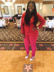
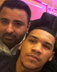
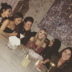
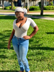
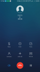
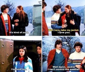

In [26]:
# ========================= CASE ANALYSIS HFM =========================

from IPython.display import HTML, display
import html, io, base64

id2name      = {0: "positive", 1: "neutral", 2: "negative"}
id2name_cap  = {0: "Positive", 1: "Neutral", 2: "Negative"}
id2abbr      = {0: "P", 1: "NT", 2: "NG"}

def _mark(pred_id, true_id):
    return f"{id2abbr[int(pred_id)]} " + ("(✓)" if int(pred_id) == int(true_id) else "(×)")

def _short_text(s, n=90):
    s = (s or "").replace("\n", " ").strip()
    return (s[:n] + "…") if len(s) > n else s

def _thumb_b64(path, size=(92, 72)):
    try:
        im = Image.open(path).convert("RGB")
        im.thumbnail(size)
    except Exception:
        im = Image.new("RGB", size, (220, 220, 220))
    buf = io.BytesIO()
    im.save(buf, format="PNG")
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("utf-8")


# ====Helpers CLARAModel HFM ====
@torch.no_grad()
def _forward_feats(model, pixel_values, input_ids, attention_mask):
    """Lấy v_feat, t_feat đúng như forward() trong CLARAModel."""
    v_out = model.vision(pixel_values)
    v_feat = v_out.last_hidden_state.mean(dim=1)  # [B, v_dim]

    t_out = model.text(input_ids=input_ids, attention_mask=attention_mask)
    t_seq = t_out.last_hidden_state                         # [B, L, t_dim]
    mask  = attention_mask.unsqueeze(-1).float()            # [B, L, 1]
    t_feat = (t_seq * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)
    return v_feat, t_feat

def _final_logits_with_feedback(model, fused):
    """
    Tái hiện đúng pipeline:
      fused → pred/veri → signal (veri - pred) → feedback → pred → logits cuối.
    """
    lg_p, pr_p = model.pred(fused)
    lg_v, pr_v = model.veri(fused)
    sig = pr_v - pr_p
    ref = model.feed(fused, sig)
    lg2, _ = model.pred(ref)
    return lg_p, lg_v, lg2

def _pred_head_logits(model, fused):
    """Chỉ dùng Prediction head trực tiếp trên fused."""
    lg_p, _ = model.pred(fused)
    return lg_p


# ==== Các variant prediction ====
@torch.no_grad()
def _predict_full(model, loader, device):
    """CLARA full: Co-Attn + Verification + Feedback (giống forward chuẩn)."""
    model.eval()
    P = []
    for b in loader:
        pv  = b['pixel_values'].to(device, non_blocking=True)
        ids = b['input_ids'].to(device, non_blocking=True)
        m   = b['attention_mask'].to(device, non_blocking=True)
        v_feat, t_feat = _forward_feats(model, pv, ids, m)
        fused = model.fusion(v_feat, t_feat)
        _, _, lg_final = _final_logits_with_feedback(model, fused)
        P.extend(lg_final.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)


@torch.no_grad()
def _predict_wo_verification(model, loader, device):
    """
    Bỏ Verification: chỉ dùng Prediction head trực tiếp, vẫn có Co-Attn.
    (Không dùng veri-head, không feedback).
    """
    model.eval()
    P = []
    for b in loader:
        pv  = b['pixel_values'].to(device, non_blocking=True)
        ids = b['input_ids'].to(device, non_blocking=True)
        m   = b['attention_mask'].to(device, non_blocking=True)
        v_feat, t_feat = _forward_feats(model, pv, ids, m)
        fused = model.fusion(v_feat, t_feat)
        lg    = _pred_head_logits(model, fused)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)


@torch.no_grad()
def _predict_wo_feedback(model, loader, device):
    """
    Bỏ feedback loop: giống ý tưởng w/o Feedback trong bài.
    Ở đây ta cũng dùng Prediction head trực tiếp trên fused (không feedback).
    """
    return _predict_wo_verification(model, loader, device)


@torch.no_grad()
def _predict_wo_coattn(model, loader, device):
    """Don't use Co-Attn: chỉ cộng hai projection vision/text."""
    model.eval()
    P = []
    for b in loader:
        pv  = b['pixel_values'].to(device, non_blocking=True)
        ids = b['input_ids'].to(device, non_blocking=True)
        m   = b['attention_mask'].to(device, non_blocking=True)
        v_feat, t_feat = _forward_feats(model, pv, ids, m)
        v_h = model.fusion.v_proj(v_feat)
        t_h = model.fusion.t_proj(t_feat)
        fused = F.layer_norm(0.5 * (v_h + t_h), (v_h.shape[-1],))
        lg    = _pred_head_logits(model, fused)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)


@torch.no_grad()
def _predict_text_only(model, loader, device):
    """Just using text branch → project text → Prediction head."""
    model.eval()
    P = []
    for b in loader:
        ids = b['input_ids'].to(device, non_blocking=True)
        m   = b['attention_mask'].to(device, non_blocking=True)
        t_out = model.text(input_ids=ids, attention_mask=m)
        t_seq = t_out.last_hidden_state
        mask  = m.unsqueeze(-1).float()
        t_feat = (t_seq * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)
        h = model.fusion.t_proj(t_feat)
        lg = _pred_head_logits(model, h)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)


@torch.no_grad()
def _predict_vision_only(model, loader, device):
    """Just using vision branch → project vision → Prediction head."""
    model.eval()
    P = []
    for b in loader:
        pv = b['pixel_values'].to(device, non_blocking=True)
        v_out = model.vision(pixel_values=pv)
        v_feat = v_out.last_hidden_state.mean(dim=1)
        h = model.fusion.v_proj(v_feat)
        lg = _pred_head_logits(model, h)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)


# ====== Chuẩn bị y_true từ HFM (đã có y_true_raw từ evaluate() trước đó) ======
y_true_np = np.array(y_true_raw, dtype=np.int64)

# Lấy prediction của từng variant trên TEST
print("\n Running predictions for Case Analysis variants (HFM)...")
pred_wo_ver = _predict_wo_verification(model, test_loader, device)
pred_wo_fb  = _predict_wo_feedback(model,     test_loader, device)
pred_wo_ca  = _predict_wo_coattn(model,      test_loader, device)
pred_text   = _predict_text_only(model,      test_loader, device)
pred_vision = _predict_vision_only(model,    test_loader, device)
pred_ours   = _predict_full(model,           test_loader, device)


def _pick_indices_weighted_random(y_true, pred_ours, others_preds, k=6, alpha=2.0):
    y_true = np.asarray(y_true)
    pred_ours = np.asarray(pred_ours)

    idx_correct = np.where(pred_ours == y_true)[0]
    if len(idx_correct) == 0:
        return []
    others = np.stack(others_preds, axis=0)   # [num_variants, N]
    y = y_true[None, :]                       # [1, N]
    wrong_mat = (others != y)                 # [num_variants, N]
    wrong_count = wrong_mat[:, idx_correct].sum(axis=0).astype(float)  # [num_correct]

    eps = 1e-6
    weights = (wrong_count + eps) ** alpha
    weights = weights / weights.sum()

    size = min(k, len(idx_correct))
    chosen = np.random.choice(idx_correct, size=size, replace=False, p=weights)
    return chosen.tolist()


others_list = [pred_wo_ver, pred_wo_fb, pred_wo_ca, pred_text, pred_vision]
sample_indices = _pick_indices_weighted_random(
    y_true_np, pred_ours, others_list, k=6, alpha=2.0
)


def render_case_table(indices, title="Case analysis of CLARA variants (HFM)"):
    if len(indices) == 0:
        print("Không tìm thấy mẫu phù hợp. Hãy tăng k hoặc nới điều kiện.")
        return

    head_cols = [
        "Sample", "Text", "Image", "True",
        "w/o Verification", "w/o Feedback", "w/o Co-Attention",
        "Text-only", "Image-only", "CLARA (Ours)"
    ]
    thead = "".join([
        f'<th style="padding:8px; border:1px solid #eee; text-align:center;">{c}</th>'
        for c in head_cols
    ])

    rows_html = []
    for idx_k, i in enumerate(indices):
        s = test_samples[i]
        text_short = html.escape(_short_text(s.text, 90))

        if s.image_path and os.path.exists(s.image_path):
            img_b64 = _thumb_b64(s.image_path)
            img_tag = f'<img src="{img_b64}" style="border-radius:6px;border:1px solid #ddd;">'
        else:
            img_tag = (
                '<div style="width:92px;height:72px;'
                'border:1px dashed #ccc;border-radius:6px;'
                'background:#fafafa;"></div>'
            )

        true_name = id2name_cap[int(y_true_np[i])]

        rows_html.append(f"""
        <tr>
          <td style="text-align:center;">({chr(ord('a')+idx_k)})</td>
          <td style="vertical-align:middle; width:30%;">{text_short}</td>
          <td style="text-align:center;">{img_tag}</td>
          <td style="text-align:center;">{true_name}</td>
          <td style="text-align:center;">{_mark(pred_wo_ver[i],  y_true_np[i])}</td>
          <td style="text-align:center;">{_mark(pred_wo_fb[i],   y_true_np[i])}</td>
          <td style="text-align:center;">{_mark(pred_wo_ca[i],   y_true_np[i])}</td>
          <td style="text-align:center;">{_mark(pred_text[i],    y_true_np[i])}</td>
          <td style="text-align:center;">{_mark(pred_vision[i],  y_true_np[i])}</td>
          <td style="text-align:center; font-weight:600;">{_mark(pred_ours[i],   y_true_np[i])}</td>
        </tr>
        """)

    # Dataset-wide metrics (Acc + F1-Macro)
    metrics_lines = []
    for name, P in {
        "w/o Verification": pred_wo_ver,
        "w/o Feedback":     pred_wo_fb,
        "w/o Co-Attention": pred_wo_ca,
        "Text-only":        pred_text,
        "Image-only":       pred_vision,
        "CLARA (Ours)":     pred_ours
    }.items():
        acc = accuracy_score(y_true_np, P)
        f1m = f1_score(y_true_np, P, average='macro')
        metrics_lines.append(f"{name}: Acc={acc:.4f} | F1-Macro={f1m:.4f}")

    metrics_html = "<br>".join(metrics_lines)

    html_table = f"""
    <div style="margin:8px 0;">
      <h4 style="margin:6px 0;">{html.escape(title)}</h4>
      <table style="width:100%; border-collapse:collapse; font-family:Arial, sans-serif; font-size:14px;">
        <thead><tr style="background:#f7f7f7;">{thead}</tr></thead>
        <tbody>{''.join(rows_html)}</tbody>
      </table>
      <div style="font-size:12px; color:#666; margin-top:6px;">
        *P = Positive, NT = Neutral, NG = Negative
      </div>
      <div style="font-size:13px; color:#444; margin-top:10px;">
        <b>Dataset-wide metrics</b><br>{metrics_html}
      </div>
    </div>
    """
    display(HTML(html_table))


# Gọi hàm để hiển thị bảng case analysis cho HFM
render_case_table(sample_indices, title="Case analysis of CLARA variants (HFM)")


In [31]:
#========================= ABLATION STUDY cho HFM (evaluation-only, TEST) =========================
from IPython.display import display

# ---- Helper: trích v_feat, t_feat (đúng với CLARAModel HFM) ----
@torch.no_grad()
def _forward_feats(model, pixel_values, input_ids, attention_mask):
    """Lấy v_feat, t_feat giống forward() trong CLARAModel."""
    v_out = model.vision(pixel_values)
    v_feat = v_out.last_hidden_state.mean(dim=1)  # [B, v_dim]

    t_out = model.text(input_ids=input_ids, attention_mask=attention_mask)
    t_seq = t_out.last_hidden_state                         # [B, L, t_dim]
    mask  = attention_mask.unsqueeze(-1).float()            # [B, L, 1]
    t_feat = (t_seq * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)
    return v_feat, t_feat

def _pred_head_logits(model, fused):
    """Dùng Prediction head trực tiếp trên fused."""
    lg_p, _ = model.pred(fused)
    return lg_p

def _final_logits_with_feedback(model, fused):
    """
    Full CLARA: fused → pred/veri → signal → feedback → pred → logits cuối.
    """
    lg_p, pr_p = model.pred(fused)
    lg_v, pr_v = model.veri(fused)
    sig = pr_v - pr_p
    ref = model.feed(fused, sig)
    lg2, _ = model.pred(ref)
    return lg2


# ---- Hàm evaluate_variant cho từng cấu hình ablation ----
@torch.no_grad()
def evaluate_variant(model, loader, device, variant="full"):
    """
    variant ∈ {
      'full', 'w/o_verification', 'w/o_feedback',
      'w/o_coattn', 'text_only', 'vision_only'
    }
    Trả về: (Acc, F1-Macro)
    """
    model.eval()
    all_preds = []
    all_labels = []

    for b in loader:
        pixel_values = b["pixel_values"].to(device, non_blocking=True)
        input_ids    = b["input_ids"].to(device, non_blocking=True)
        attention    = b["attention_mask"].to(device, non_blocking=True)
        labels       = b["labels"].cpu().numpy()   # giữ label ở CPU

        # ----- Tùy variant, chọn pipeline -----
        if variant == "full":
            # Forward chuẩn (dùng logits cuối trong dict)
            out = model(pixel_values, input_ids=input_ids, attention_mask=attention)
            logits = out["logits"]

        elif variant == "w/o_verification":
            # Có Co-Attn, bỏ verification + feedback:
            v_feat, t_feat = _forward_feats(model, pixel_values, input_ids, attention)
            fused = model.fusion(v_feat, t_feat)
            logits = _pred_head_logits(model, fused)

        elif variant == "w/o_feedback":
            # Bỏ feedback: tương tự dùng Prediction head trực tiếp
            v_feat, t_feat = _forward_feats(model, pixel_values, input_ids, attention)
            fused = model.fusion(v_feat, t_feat)
            logits = _pred_head_logits(model, fused)

        elif variant == "w/o_coattn":
            # Không Co-Attn: cộng 2 projection vision/text → norm → pred head
            v_feat, t_feat = _forward_feats(model, pixel_values, input_ids, attention)
            v_h = model.fusion.v_proj(v_feat)
            t_h = model.fusion.t_proj(t_feat)
            fused = F.layer_norm(0.5 * (v_h + t_h), (v_h.shape[-1],))
            logits = _pred_head_logits(model, fused)

        elif variant == "text_only":
            # Chỉ text branch → project text → pred head
            t_out = model.text(input_ids=input_ids, attention_mask=attention)
            t_seq = t_out.last_hidden_state
            mask  = attention.unsqueeze(-1).float()
            t_feat = (t_seq * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)
            fused = model.fusion.t_proj(t_feat)
            logits = _pred_head_logits(model, fused)

        elif variant == "vision_only":
            # Chỉ vision branch → project vision → pred head
            v_out = model.vision(pixel_values)
            v_feat = v_out.last_hidden_state.mean(dim=1)
            fused = model.fusion.v_proj(v_feat)
            logits = _pred_head_logits(model, fused)

        else:
            raise ValueError(f"Unknown variant: {variant}")

        preds = logits.argmax(dim=-1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

    all_preds = np.array(all_preds, dtype=np.int64)
    all_labels = np.array(all_labels, dtype=np.int64)

    acc  = accuracy_score(all_labels, all_preds)
    f1_m = f1_score(all_labels, all_preds, average="macro")
    return acc, f1_m


# =========================
# Run ABLATION trên TEST (HFM)
# =========================
abl_rows = []
for name, key in [
    ("Full",             "full"),
    ("w/o Verification", "w/o_verification"),
    ("w/o Feedback",     "w/o_feedback"),
    ("w/o Co-Attention", "w/o_coattn"),
    ("Text-only",        "text_only"),
    ("Vision-only",      "vision_only"),
]:
    acc, f1m = evaluate_variant(model, test_loader, device, variant=key)
    abl_rows.append({"Variant": name, "Acc": acc, "F1-Macro": f1m})

abl_df = pd.DataFrame(abl_rows)
best_idx_abl = abl_df['F1-Macro'].idxmax()

print("\n" + "="*66)
print("ABLATION STUDY (evaluation-only, TEST set — HFM)")
print("="*66)

# Bảng đẹp với pandas Styler (dùng F1-Macro)
def _style_abl(df, best_idx):
    sty = (
        df.copy()
        .style
        .hide(axis="index")
        .format({"Acc": "{:.4f}", "F1-Macro": "{:.4f}"})
        .set_properties(**{
            "text-align": "center",
            "padding": "6px",
            "border": "1px solid #eee",
        })
        .set_table_styles([
            {"selector": "th", "props": [
                ("text-align", "center"),
                ("padding", "6px"),
                ("border", "1px solid #eee"),
                ("background-color", "#f7f7f7"),
            ]},
            {"selector": "tbody tr:nth-child(even)",
             "props": [("background-color", "#fafafa")]},
        ])
        .background_gradient(subset=["F1-Macro"], cmap="Blues")
    )
    def _highlight_best(row):
        color = "#e99935" if row.name == best_idx else ""
        return ["background-color: {}".format(color) if col == "F1-Macro" else ""
                for col in row.index]
    sty = sty.apply(_highlight_best, axis=1)
    return sty

display(_style_abl(abl_df, best_idx_abl))

print("\n🏆 Best variant by F1-Macro:")
print(
    abl_df.loc[[best_idx_abl]].to_string(
        index=False,
        formatters={
            "Acc":      lambda x: f"{x:.4f}",
            "F1-Macro": lambda x: f"{x:.4f}",
        },
    )
)



ABLATION STUDY (evaluation-only, TEST set — HFM)


Variant,Acc,F1-Macro
Full,0.8825,0.8799
w/o Verification,0.8846,0.8820
w/o Feedback,0.8846,0.8820
w/o Co-Attention,0.8306,0.8301
Text-only,0.7933,0.7932
Vision-only,0.6716,0.4439



🏆 Best variant by F1-Macro:
         Variant    Acc F1-Macro
w/o Verification 0.8846   0.8820
